# Forest Example
Let's take the case of an agent who is moving in a forest, looking for water.

<img src="../imgs/forest.png" style="width: 40%;" />

Now suppose that each station from A to F is a state. Each state is described only by a binary vector $s = \left[N, S, E, W\right]$, where each dimension represents the availability of a path is one of the possible directions.

In [1]:
import sys
import os
sys.path.append(os.path.abspath("../"))

import gymnasium as gym 
from foundation import environments
import matplotlib.pyplot as plt 
import seaborn as sns 
from collections import defaultdict
import pandas as pd 
import numpy as np 
import torch 

## Explore observations

In [2]:
env = gym.make('ForestExampleEnv-v0')

In [3]:
observation, info = env.reset()
print(observation, info)

0 {'actions': array([0, 1, 1, 1])}


In [4]:
for _ in range(6):
    options = [i for i, a in enumerate(env.unwrapped.available_actions[observation]) if a == 1]
    action = np.random.choice(options)  # pick up an available action
    observation, reward, terminated, truncated, info = env.step(action)
    print(action, observation, reward, terminated, truncated, info)
    if terminated or truncated:
        print("============End of episode============")
        observation, info = env.reset()
env.close()

3 2 0 False False {'actions': array([0, 0, 1, 1])}
3 4 0 False False {'actions': array([1, 1, 0, 0])}
1 2 0 False False {'actions': array([0, 0, 1, 1])}
2 0 0 False False {'actions': array([0, 1, 1, 1])}
1 7 1 True False {'actions': array([0, 0, 1, 0])}
============End of episode============
2 1 0 False False {'actions': array([0, 0, 1, 1])}


# Tabular methods

### Q-Learning Agent

In [5]:
from foundation.agents.forest import ForestAgentQlearning

In [6]:
learning_rate = 0.001
n_episodes = 5_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

state, _ = env.reset()

agent = ForestAgentQlearning(
    environment=env, learning_rate=learning_rate, 
    epsilon=start_epsilon, epsilon_decay=epsilon_decay, final_epsilon=final_epsilon, gamma=.95
)

In [7]:
print(agent.Q)

[[-inf   0.   0.   0.]
 [-inf -inf   0.   0.]
 [-inf -inf   0.   0.]
 [  0.   0. -inf -inf]
 [  0.   0. -inf -inf]
 [-inf -inf   0. -inf]
 [-inf   0. -inf -inf]
 [-inf -inf   0. -inf]]


**Training**

In [8]:
from tqdm import tqdm

In [9]:
env = gym.make('ForestExampleEnv-v0')
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)
for episode in tqdm(range(n_episodes)):
    state, info = env.reset()
    done = False
    # explore the forest
    while not done:
        action = agent.policy(state)
        s_prime, reward, terminated, truncated, info = env.step(action=action)
        # update
        agent.update(state, action, reward, terminated, s_prime)
        done = terminated or truncated
        state = s_prime
    agent.decay_epsilon()

100%|██████████| 5000/5000 [00:00<00:00, 7221.84it/s]


**Training stats**

In [10]:
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_theme(style="whitegrid")

In [11]:
def conv(a, win=100):
    return np.convolve(a, np.ones(win), mode='same') / win

In [12]:
w = 10
rewards = conv(np.array(env.return_queue).flatten(), win=w)
lengths = conv(np.array(env.length_queue).flatten(), win=w)
error = conv(np.array(agent.training_error).flatten(), win=w)

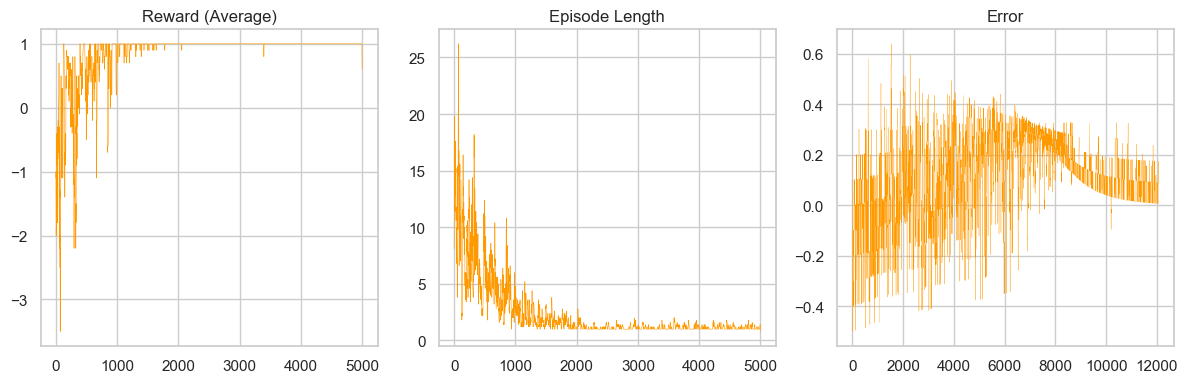

In [13]:
fig, ax = plt.subplots(figsize=(12, 4), ncols=3)
sns.lineplot(x=range(len(rewards)), y=rewards, ax=ax[0], c='#FF9900', linewidth=.4)
ax[0].set_title('Reward (Average)')
sns.lineplot(x=range(len(lengths)), y=lengths, ax=ax[1], c='#FF9900', linewidth=.4)
ax[1].set_title('Episode Length')
sns.lineplot(x=range(len(error)), y=error, ax=ax[2], c='#FF9900', linewidth=.2)
ax[2].set_title('Error')
plt.tight_layout()
plt.show()

**Q-values**

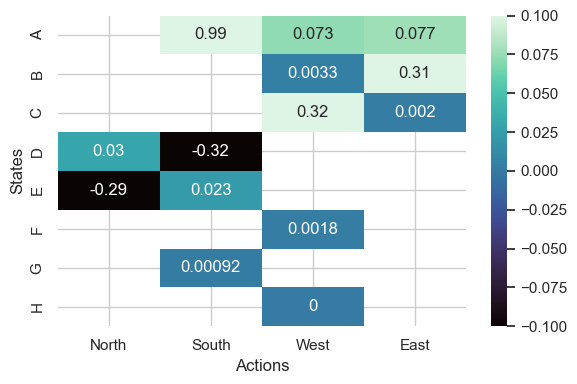

In [14]:
fig, ax = plt.subplots(figsize=(6, 4), ncols=1)
sns.heatmap(agent.Q, annot=True, cmap='mako', ax=ax)
ax.set(xlabel="Actions", ylabel="States")
ax.set_yticklabels(list('ABCDEFGH'))
ax.set_xticklabels(['North', 'South', 'West', 'East'])
plt.tight_layout()
plt.show()

### SARSA

In [15]:
from foundation.agents.forest import ForestAgentSarsa

In [16]:
learning_rate = 0.001
n_episodes = 5_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

env = gym.make('ForestExampleEnv-v0')
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)

s_agent = ForestAgentSarsa(
    environment=env, learning_rate=learning_rate, epsilon=start_epsilon, epsilon_decay=epsilon_decay, final_epsilon=final_epsilon, gamma=.95
)

In [17]:
observation, info = env.reset()

for episode in tqdm(range(n_episodes)):
    state, info = env.reset()
    done = False
    # explore the forest
    while not done:
        action = s_agent.policy(state)
        s_prime, reward, terminated, truncated, info = env.step(action=action)
        # update
        s_agent.update(state, action, reward, terminated, s_prime)
        done = terminated or truncated
        state = s_prime
    s_agent.decay_epsilon()

100%|██████████| 5000/5000 [00:01<00:00, 4928.97it/s]


In [18]:
w = 100
rewards = conv(np.array(env.return_queue).flatten(), win=w)
lengths = conv(np.array(env.length_queue).flatten(), win=w)
error = conv(np.array(agent.training_error).flatten(), win=w)

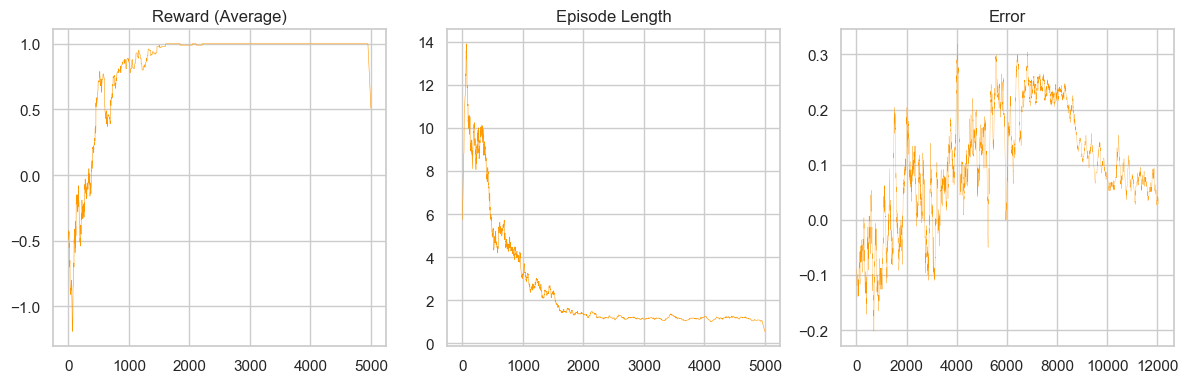

In [19]:
fig, ax = plt.subplots(figsize=(12, 4), ncols=3)
sns.lineplot(x=range(len(rewards)), y=rewards, ax=ax[0], c='#FF9900', linewidth=.4)
ax[0].set_title('Reward (Average)')
sns.lineplot(x=range(len(lengths)), y=lengths, ax=ax[1], c='#FF9900', linewidth=.4)
ax[1].set_title('Episode Length')
sns.lineplot(x=range(len(error)), y=error, ax=ax[2], c='#FF9900', linewidth=.2)
ax[2].set_title('Error')
plt.tight_layout()
plt.show()

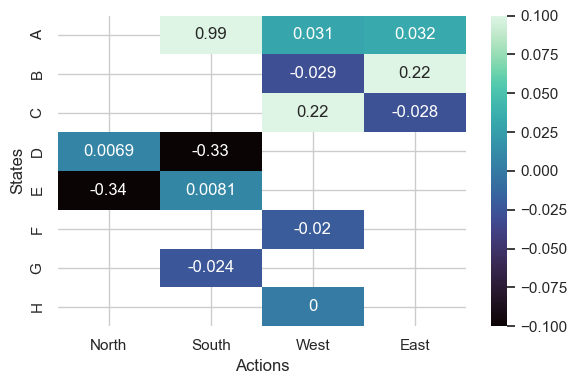

In [20]:
fig, ax = plt.subplots(figsize=(6, 4), ncols=1)
sns.heatmap(s_agent.Q, annot=True, cmap='mako', ax=ax)
ax.set(xlabel="Actions", ylabel="States")
ax.set_yticklabels(list('ABCDEFGH'))
ax.set_xticklabels(['North', 'South', 'West', 'East'])
plt.tight_layout()
plt.show()

### MonteCarlo

In [21]:
from foundation.agents.forest import ForestAgentMC

In [22]:
learning_rate = 0.001
n_episodes = 5_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

env = gym.make('ForestExampleEnv-v0')
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)

mc_agent = ForestAgentMC(
    environment=env, learning_rate=learning_rate, epsilon=start_epsilon, epsilon_decay=epsilon_decay, final_epsilon=final_epsilon, gamma=.95
)

In [23]:
for episode in tqdm(range(n_episodes)):
    mc_agent.update()
    mc_agent.decay_epsilon()

100%|██████████| 5000/5000 [00:01<00:00, 2511.57it/s]


In [24]:
w = 100
rewards = conv(np.array(env.return_queue).flatten(), win=w)
lengths = conv(np.array(env.length_queue).flatten(), win=w)
error = conv(np.array(mc_agent.training_error).flatten(), win=w)

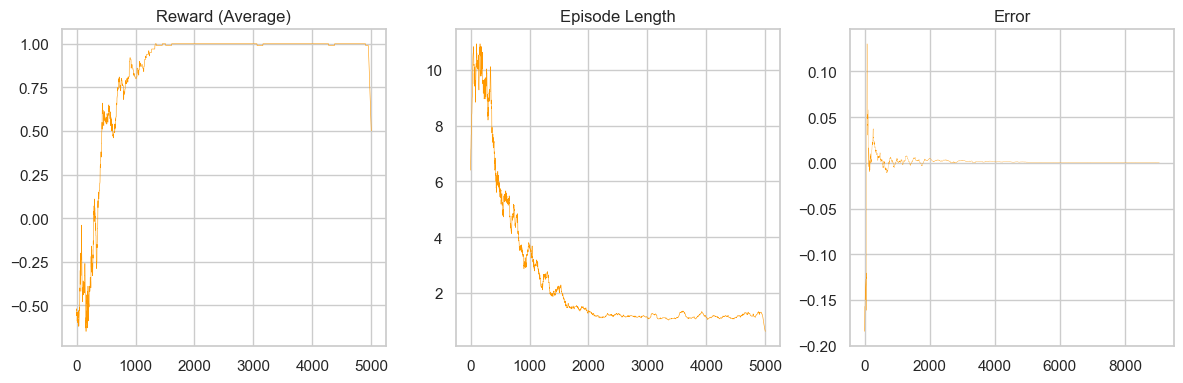

In [25]:
fig, ax = plt.subplots(figsize=(12, 4), ncols=3)
sns.lineplot(x=range(len(rewards)), y=rewards, ax=ax[0], c='#FF9900', linewidth=.4)
ax[0].set_title('Reward (Average)')
sns.lineplot(x=range(len(lengths)), y=lengths, ax=ax[1], c='#FF9900', linewidth=.4)
ax[1].set_title('Episode Length')
sns.lineplot(x=range(len(error)), y=error, ax=ax[2], c='#FF9900', linewidth=.2)
ax[2].set_title('Error')
plt.tight_layout()
plt.show()

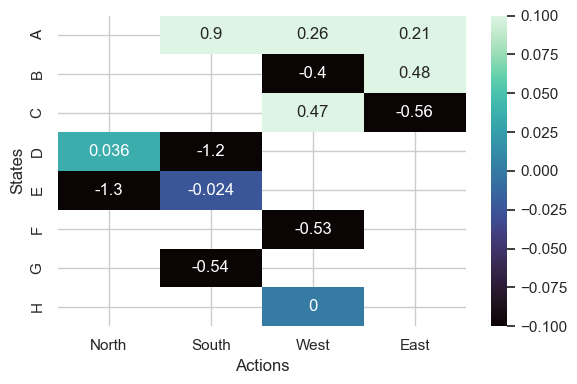

In [26]:
fig, ax = plt.subplots(figsize=(6, 4), ncols=1)
sns.heatmap(mc_agent.Q, annot=True, cmap='mako', ax=ax)
ax.set(xlabel="Actions", ylabel="States")
ax.set_yticklabels(list('ABCDEFGH'))
ax.set_xticklabels(['North', 'South', 'West', 'East'])
plt.tight_layout()
plt.show()

## Approximate methods

### Q-Learning

In [27]:
from foundation.agents.forest import ForestAgentQlearningVFA

In [28]:
# Recreate the environment to avoid overloading of record stats wrapper
nenv = gym.make('ForestExampleEnv-v0')

In [29]:
learning_rate = 0.001
n_episodes = 1_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

vfa_agent = ForestAgentQlearningVFA(
    environment=nenv, learning_rate=learning_rate, epsilon=start_epsilon, epsilon_decay=epsilon_decay, final_epsilon=final_epsilon, gamma=.95
)

**Training**

In [30]:
nenv = gym.wrappers.RecordEpisodeStatistics(nenv, buffer_length=n_episodes)
for episode in tqdm(range(n_episodes)):
    state, info = nenv.reset()
    done = False
    # explore the forest
    while not done:
        action = vfa_agent.policy(state)
        s_prime, reward, terminated, truncated, info = nenv.step(action=action)
        # update
        vfa_agent.update(state, action, reward, s_prime)
        done = terminated or truncated
        state = s_prime
    vfa_agent.decay_epsilon()

100%|██████████| 1000/1000 [00:06<00:00, 144.73it/s]


**Training stats**

In [31]:
w = 100
rewards = conv(np.array(nenv.return_queue).flatten(), win=w)
lengths = conv(np.array(nenv.length_queue).flatten(), win=w)
error = conv(np.array(vfa_agent.training_error).flatten(), win=w)

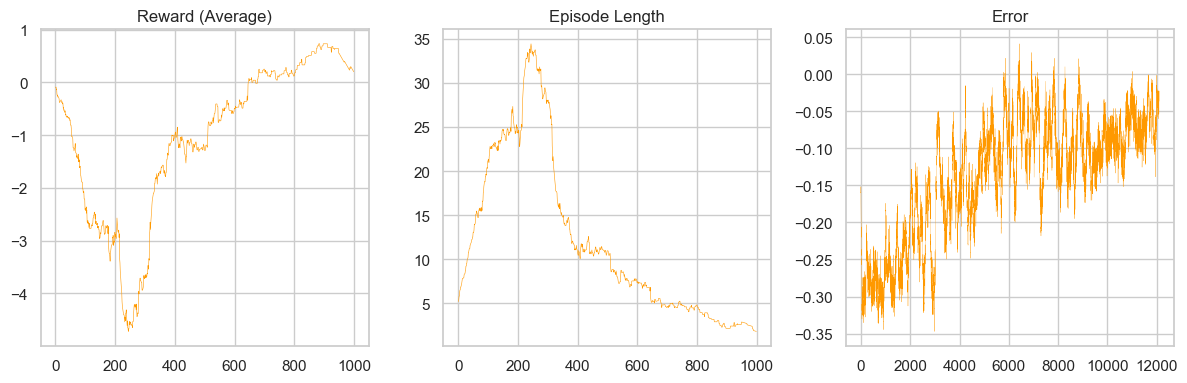

In [32]:
fig, ax = plt.subplots(figsize=(12, 4), ncols=3)
sns.lineplot(x=range(len(rewards)), y=rewards, ax=ax[0], c='#FF9900', linewidth=.4)
ax[0].set_title('Reward (Average)')
sns.lineplot(x=range(len(lengths)), y=lengths, ax=ax[1], c='#FF9900', linewidth=.4)
ax[1].set_title('Episode Length')
sns.lineplot(x=range(len(error)), y=error, ax=ax[2], c='#FF9900', linewidth=.2)
ax[2].set_title('Error')
plt.tight_layout()
plt.show()

In [33]:
q_table = np.ones((nenv.observation_space.n, nenv.action_space.n)) * -np.inf 
for state in range(nenv.observation_space.n):
    options = [i for i, a in enumerate(nenv.unwrapped.available_actions[state]) if a > 0]
    for action in options:
        q_table[state, action] = vfa_agent.q(state, action).detach().numpy()

**Q-values**

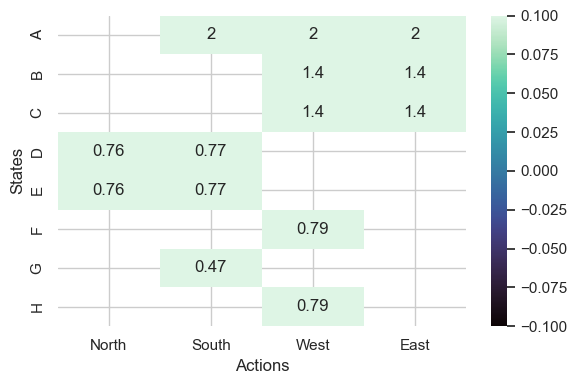

In [34]:
fig, ax = plt.subplots(figsize=(6, 4), ncols=1)
sns.heatmap(q_table, annot=True, cmap='mako', ax=ax)
ax.set(xlabel="Actions", ylabel="States")
ax.set_yticklabels(list('ABCDEFGH'))
ax.set_xticklabels(['North', 'South', 'West', 'East'])
plt.tight_layout()
plt.show()

In [35]:
vfa_agent.w

tensor([[0.3821, 0.2976, 1.0000, 1.0000],
        [0.3821, 0.4726, 0.5895, 0.5879],
        [1.0000, 0.7529, 0.7892, 0.6930],
        [1.0000, 0.7529, 0.5992, 0.6930]], dtype=torch.float64,
       requires_grad=True)

In [36]:
# Evaluate actions
actions = ['north', 'south', 'east', 'west']
state = torch.tensor([0, 1, 1, 1], dtype=float, requires_grad=False) # State like A
values = (state @ vfa_agent.w)
for i in range(vfa_agent.env.action_space.n):
    if state[i] > 0:
        print(f"go to {actions[i]:5} {values[i]}")

go to south 1.9783416268977745
go to east  1.977890065444998
go to west  1.9738558408507618


In [37]:
state = torch.tensor([0, 1, 1, 1], dtype=float, requires_grad=False) # State like A
state @ vfa_agent.w 

tensor([2.3821, 1.9783, 1.9779, 1.9739], dtype=torch.float64,
       grad_fn=<SqueezeBackward4>)

### SARSA

In [38]:
from foundation.agents.forest import ForestAgentSarsaVFA

In [39]:
nenv = gym.make('ForestExampleEnv-v0')
nenv = gym.wrappers.RecordEpisodeStatistics(nenv, buffer_length=n_episodes)

In [42]:
learning_rate = 0.001
n_episodes = 1_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

vfa_s_agent = ForestAgentQlearningVFA(
    environment=nenv, learning_rate=learning_rate, epsilon=start_epsilon, epsilon_decay=epsilon_decay, final_epsilon=final_epsilon, gamma=.95
)

In [43]:
for episode in tqdm(range(n_episodes)):
    state, info = nenv.reset()
    done = False
    # explore the forest
    while not done:
        action = vfa_s_agent.policy(state)
        s_prime, reward, terminated, truncated, info = nenv.step(action=action)
        # update
        vfa_s_agent.update(state, action, reward, s_prime)
        done = terminated or truncated
        state = s_prime
    vfa_s_agent.decay_epsilon()

100%|██████████| 1000/1000 [00:07<00:00, 129.27it/s]


In [44]:
w = 100
rewards = conv(np.array(nenv.return_queue).flatten(), win=w)
lengths = conv(np.array(nenv.length_queue).flatten(), win=w)
error = conv(np.array(vfa_s_agent.training_error).flatten(), win=w)

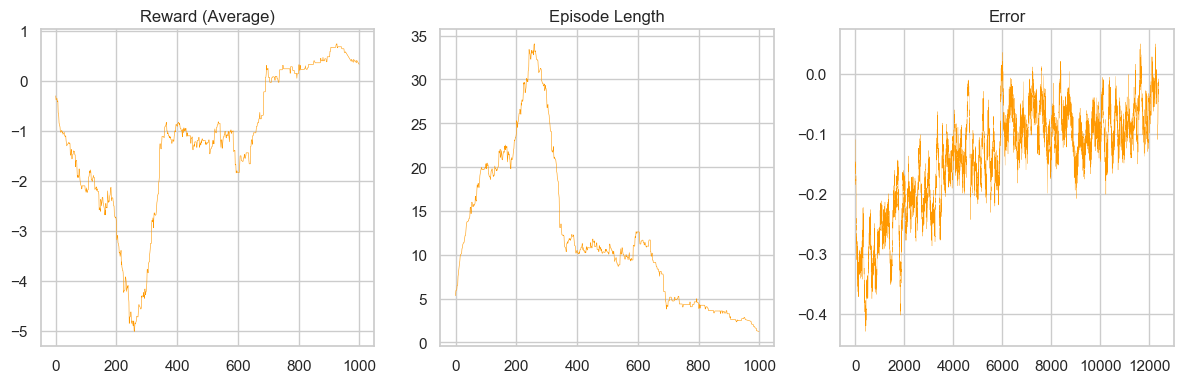

In [45]:
fig, ax = plt.subplots(figsize=(12, 4), ncols=3)
sns.lineplot(x=range(len(rewards)), y=rewards, ax=ax[0], c='#FF9900', linewidth=.4)
ax[0].set_title('Reward (Average)')
sns.lineplot(x=range(len(lengths)), y=lengths, ax=ax[1], c='#FF9900', linewidth=.4)
ax[1].set_title('Episode Length')
sns.lineplot(x=range(len(error)), y=error, ax=ax[2], c='#FF9900', linewidth=.2)
ax[2].set_title('Error')
plt.tight_layout()
plt.show()

In [46]:
q_table = np.ones((nenv.observation_space.n, nenv.action_space.n)) * -np.inf 
for state in range(nenv.observation_space.n):
    options = [i for i, a in enumerate(nenv.unwrapped.available_actions[state]) if a > 0]
    for action in options:
        q_table[state, action] = vfa_s_agent.q(state, action).detach().numpy()

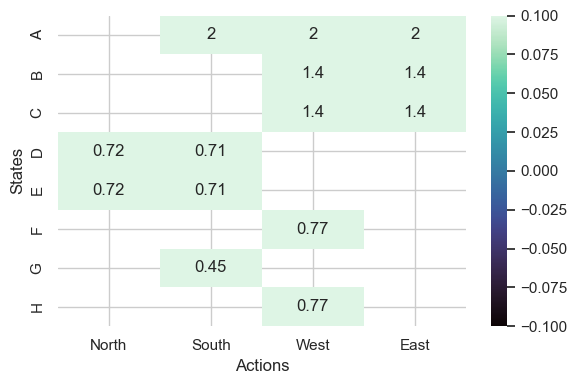

In [47]:
fig, ax = plt.subplots(figsize=(6, 4), ncols=1)
sns.heatmap(q_table, annot=True, cmap='mako', ax=ax)
ax.set(xlabel="Actions", ylabel="States")
ax.set_yticklabels(list('ABCDEFGH'))
ax.set_xticklabels(['North', 'South', 'West', 'East'])
plt.tight_layout()
plt.show()

### MonteCarlo VFA

In [48]:
from foundation.agents.forest import ForestAgentMCVFA

In [49]:
nenv = gym.make('ForestExampleEnv-v0')
nenv = gym.wrappers.RecordEpisodeStatistics(nenv, buffer_length=n_episodes)

In [52]:
learning_rate = 0.001
n_episodes = 1_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

vfa_mc_agent = ForestAgentMCVFA(
    environment=nenv, learning_rate=learning_rate, epsilon=start_epsilon, epsilon_decay=epsilon_decay, final_epsilon=final_epsilon, gamma=.95
)

In [53]:
for episode in tqdm(range(n_episodes)):
    vfa_mc_agent.update()
    vfa_mc_agent.decay_epsilon()

100%|██████████| 1000/1000 [00:03<00:00, 302.97it/s]


In [54]:
w = 100
rewards = conv(np.array(nenv.return_queue).flatten(), win=w)
lengths = conv(np.array(nenv.length_queue).flatten(), win=w)
error = conv(np.array(vfa_mc_agent.training_error).flatten(), win=w)

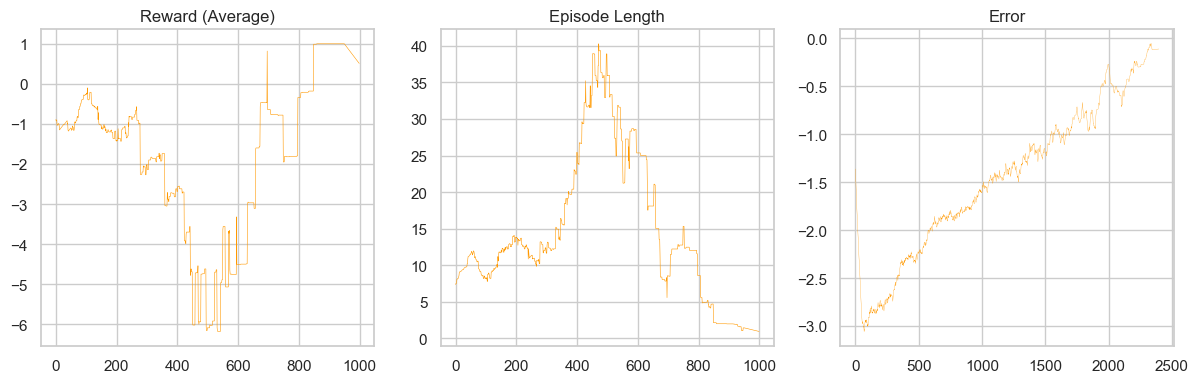

In [55]:
fig, ax = plt.subplots(figsize=(12, 4), ncols=3)
sns.lineplot(x=range(len(rewards)), y=rewards, ax=ax[0], c='#FF9900', linewidth=.4)
ax[0].set_title('Reward (Average)')
sns.lineplot(x=range(len(lengths)), y=lengths, ax=ax[1], c='#FF9900', linewidth=.4)
ax[1].set_title('Episode Length')
sns.lineplot(x=range(len(error)), y=error, ax=ax[2], c='#FF9900', linewidth=.2)
ax[2].set_title('Error')
plt.tight_layout()
plt.show()

In [56]:
q_table = np.ones((nenv.observation_space.n, nenv.action_space.n)) * -np.inf 
for state in range(nenv.observation_space.n):
    options = [i for i, a in enumerate(nenv.unwrapped.available_actions[state]) if a > 0]
    for action in options:
        q_table[state, action] = vfa_mc_agent.q(state, action).detach().numpy()

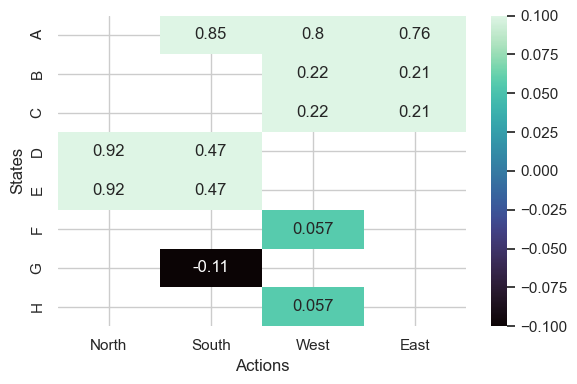

In [57]:
fig, ax = plt.subplots(figsize=(6, 4), ncols=1)
sns.heatmap(q_table, annot=True, cmap='mako', ax=ax)
ax.set(xlabel="Actions", ylabel="States")
ax.set_yticklabels(list('ABCDEFGH'))
ax.set_xticklabels(['North', 'South', 'West', 'East'])
plt.tight_layout()
plt.show()